In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib import style
from itertools import cycle
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.preprocessing import Normalizer

from raman_lib.preprocessing import (BaselineCorrector,
                                     RangeLimiter,
                                     SavGolFilter)
from raman_lib.crossvalidation import randomized_cv
from raman_lib.visualization import plot_confusion_matrix, plot_roc_curve

from raman_lib.misc import load_data

style.use("default")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

## Setup

In [84]:
# Path where the data is stored
data_path = "./data/rec_ecoli_S_12h.csv"

# Spectral range to analyze
# Use 'None' to use the whole range'
wn_min = 450
wn_max = 1800

# Window size for smoothing the spectra
# Higher means stronger smoothing
sg_window = 15

n_trials = 20  # Randomized repetitions
n_folds = 5  # Cross validations

## Load Data

In [85]:
data = load_data(data_path)

if "file" in data.columns:
    X = data.drop(columns=["label", "file"])
else:
    X = data.drop(columns=["label"])
wns = np.asarray(X.columns.astype(float))
X = np.asarray(X)

y = np.asarray(data.label)
y, y_key = pd.factorize(y)

for i, label in enumerate(y_key):
    print(f"{label}: {i}")

non-induced: 0
induced: 1


## Preprocessing

In [86]:
X_orig = X.copy()
X = BaselineCorrector().fit_transform(X)

rl = RangeLimiter(lim=(wn_min, wn_max), reference=wns)
X = rl.fit_transform(X)
wns_reduced = wns[rl.lim_[0]:rl.lim_[1]]

X = SavGolFilter().fit_transform(X)

X = Normalizer().fit_transform(X)

In [87]:
clf = Pipeline(steps=[("pca", PCA()),
                      ("lda", LinearDiscriminantAnalysis())])

p_grid = {
    "pca__n_components": range(5, 6)
}

scoring = [
    "accuracy",
    "f1"
]

clf, ct_results, cv_results = randomized_cv(clf, X, y,
                                            param_grid=p_grid,
                                            ct_scoring=scoring,
                                            n_jobs=-1)


  0%|          | 0/20 [00:00<?, ?it/s]

Training Accuracy: 0.843
Training F1-score: 0.841

Test Accuracy: 0.829
Test F1-score: 0.822


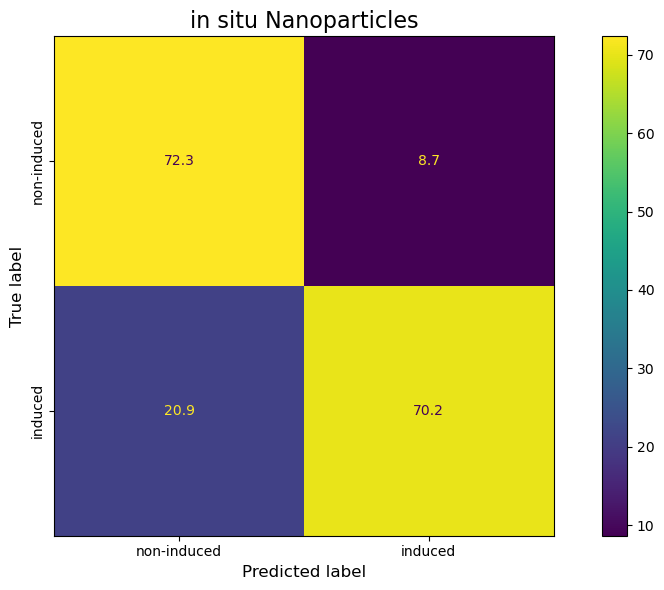

In [88]:
plot_confusion_matrix(ct_results["y_pred"], y, y_key, "in situ Nanoparticles")

In [81]:
ct_results["conf_scores"].shape

(20, 104)

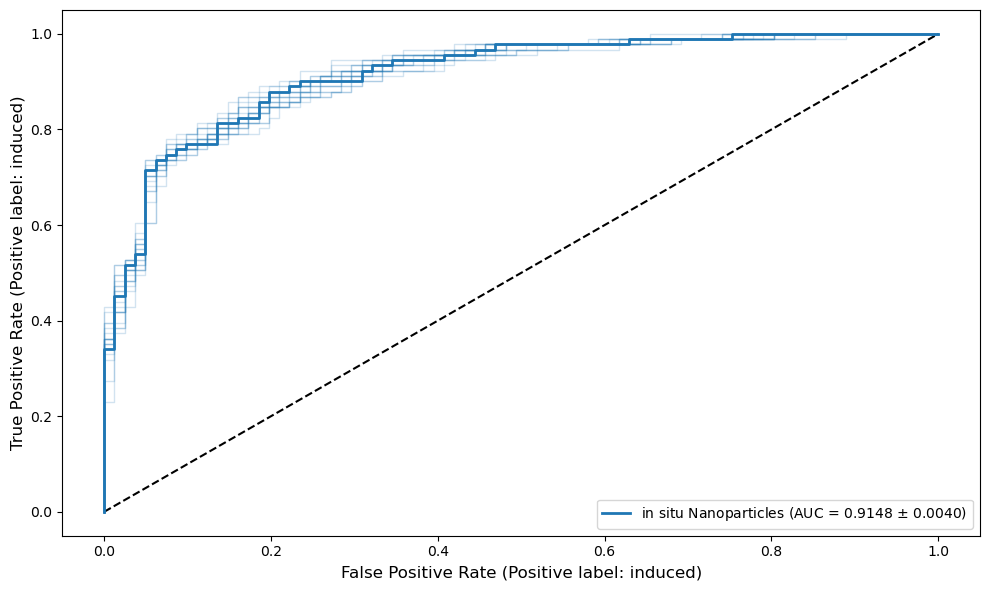

In [89]:
#rocs = {}
#aucs_all = {}

name = "in situ Nanoparticles"

roc, aucs = plot_roc_curve(ct_results["conf_scores"], y, y_key, name)

rocs[name] = roc
aucs_all[name] = aucs

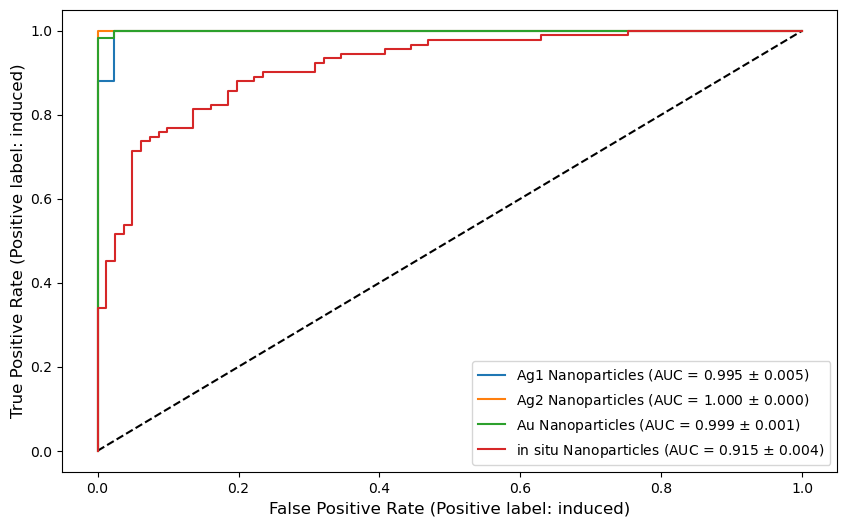

In [95]:
fig, ax = plt.subplots()

ax.plot([0, 1], [0, 1], color="black", linestyle="dashed")

for i, (key, val) in enumerate(rocs.items()):
    ax.plot(val[0], val[1], color=f"C{i}", linewidth=1.5,
        label=f"{key} (AUC = {aucs_all[key][0]:.3f} $\pm$ {aucs_all[key][1]:.3f})")

ax.set_xlabel(
    f"False Positive Rate (Positive label: {y_key[1]})", fontsize=12)
ax.set_ylabel(
    f"True Positive Rate (Positive label: {y_key[1]})", fontsize=12)

ax.legend(loc="lower right")